In [1]:
import pandas as pd
from sklearn.ensemble import IsolationForest
from sklearn.datasets import make_moons, make_blobs
import numpy as np
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt

## Create dataset

In [2]:
x_column = 'Temperature'
y_column = 'Light Ambience'
columns = [x_column, y_column]

In [3]:
dataset = pd.DataFrame(make_blobs(centers=[[16, 0], [21, 1200], [19, 600]], 
                                  cluster_std=[[1, 0], [1, 200], [0.7, 180]], 
                                  n_features=2, 
                                  n_samples=300)[0],
                       columns=columns)

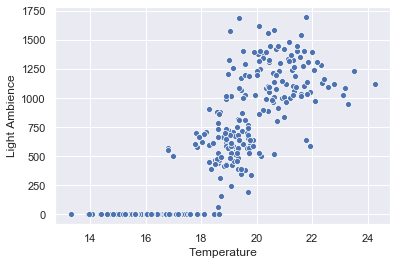

In [4]:
ax = sns.scatterplot(x=x_column, y=y_column, data=dataset)

## Add outliers

In [5]:
outliers = pd.DataFrame(np.random.uniform(low=[13, 0], high=[24, 2000], size=(30,2)), columns=columns)

In [6]:
dataset_with_outliers = dataset.append(outliers)

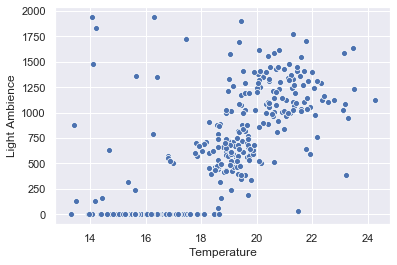

In [7]:
ax = sns.scatterplot(x=x_column, y=y_column, data=dataset_with_outliers)

## Fit our algorithm

In [8]:
model = IsolationForest()

In [9]:
model.fit(dataset_with_outliers)

IsolationForest(behaviour='deprecated', bootstrap=False, contamination='auto',
                max_features=1.0, max_samples='auto', n_estimators=100,
                n_jobs=None, random_state=None, verbose=0, warm_start=False)

## Visualize our outliers

In [10]:
outliers = model.predict(dataset_with_outliers)

In [11]:
outlier_column = 'is_outlier'

In [12]:
dataset_with_outliers[outlier_column] = outliers
dataset_with_outliers[outlier_column] = dataset_with_outliers[outlier_column].replace(-1, 'Outlier')
dataset_with_outliers[outlier_column] = dataset_with_outliers[outlier_column].replace(1, 'Normal')

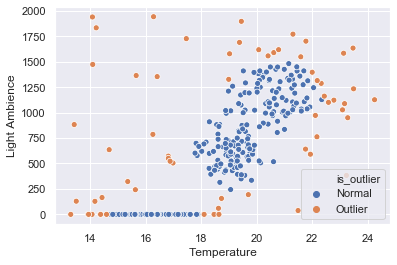

In [13]:
ax = sns.scatterplot(x=x_column, y=y_column, hue=outlier_column, data=dataset_with_outliers)

## Save model

In [14]:
from joblib import dump, load
dump(model, './model.joblib')

['./model.joblib']

## Upload model

In [15]:
from zipfile import ZipFile
from io import BytesIO
import requests
from requests.auth import HTTPBasicAuth
def upload_model(model_name, description, upload_url, api_key, api_secret):
    
    zipfile_name = 'model.zip'
    # Create a zip
    with ZipFile('model.zip', 'w') as zipfile:
       # Add multiple files to the zip
       zipfile.write('model.joblib')
        
    with open('model.zip', 'rb') as f:
        upload_file = BytesIO(f.read())
        
    # upload to waylay
    resp = requests.post(upload_url,
                         files={"file": ('model.zip', upload_file)},
                         data={"name": model_name, "framework": "sklearn", "description": description},
                         auth=HTTPBasicAuth(api_key, api_secret))

    return resp.json()

In [16]:
# https://docs.waylay.io/api/rest/#authentication
api_key = 'your api key'
api_secret = 'your api secret'
byom_url = 'https://byoml.waylay.io/models'
model_name = 'outlier-detection'
description = 'This model detects outliers expecting two features: temperature and light ambience'
print(
    upload_model(
        model_name,
        description,
        byom_url,  
        api_key, 
        api_secret
    )
)

{'message': 'Model successfully uploaded'}


## Check if model and uploaded model act the same

In [18]:
instances = [[0,0], [17,0], [20, 1200], [25, 1300], [22, 1300], [22, 1750]]

In [19]:
model.predict(instances)

array([-1,  1,  1, -1,  1, -1])

In [20]:
response = requests.post(byom_url + '/' + model_name + '/predict',
                         json = {"instances": instances},
                         auth=HTTPBasicAuth(api_key, api_secret)).json()
response

{'predictions': [-1, 1, 1, -1, 1, -1]}

In [21]:
model.predict(instances) == response['predictions']

array([ True,  True,  True,  True,  True,  True])

## Delete model

In [ ]:
requests.delete(byom_url + '/' + model_name,
                auth=HTTPBasicAuth(api_key, api_secret)).json()